In [65]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import skmultiflow as sci_flow
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.evaluation import EvaluatePrequential

In [74]:
target_value_min = 0
target_value_max = 15
ambient_temp = 10
varibation_val = 7



13.5


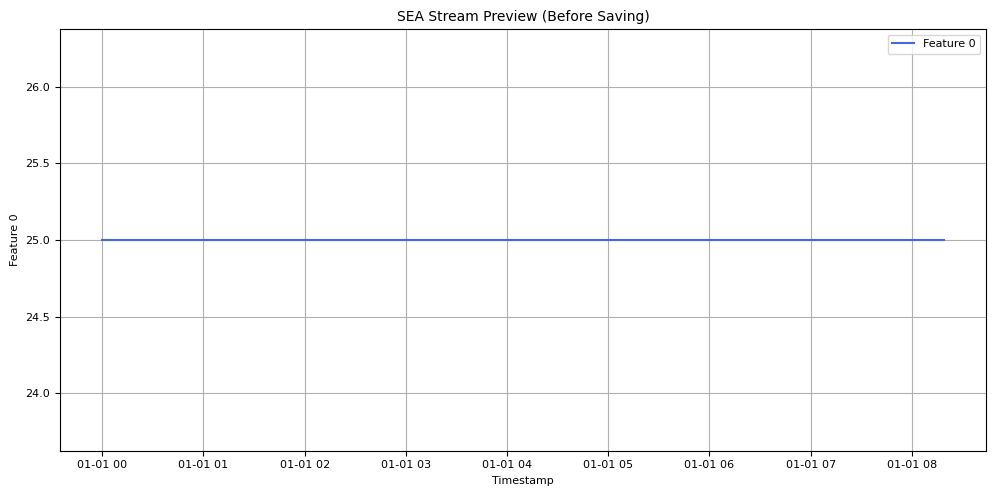

✅ Exported to sea_stream_with_time.csv


In [ ]:
range = target_value_max - target_value_min

# 1. Create a stream
stream = sci_flow.data.SEAGenerator(random_state=42)
stream.restart()


# 2. Get samples
n_samples = 500
X, y = stream.next_sample(n_samples)
X = np.array(X)
feature_0 = X[:, 0] #+ mean_value
# 3. Create a time index or timestamp column
timestamps = pd.date_range(start="2023-01-01", periods=n_samples, freq="T")
scaled = (feature_0 - feature_0.min()) / (feature_0.max() - feature_0.min())
recast = scaled * range + ambient_temp


df = pd.DataFrame({
    'timestamp': timestamps,
    'feature_0': recast,   # pick the feature you want
    'target': y
})
                        # Append target labels



df['timestamp'] = pd.to_datetime(df['timestamp'])
df['feature_0'] = pd.to_numeric(df['feature_0'], errors='coerce')


plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'].to_numpy(), df['feature_0'].to_numpy(), label='Feature 0', color='royalblue')
plt.xlabel("Timestamp")
plt.ylabel("Feature 0")
plt.title("SEA Stream Preview (Before Saving)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Export to CSV
df.to_csv("sea_stream_with_time.csv", index=False)

print("✅ Exported to sea_stream_with_time.csv")